In [78]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne
import math

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
import glob
import os


import seaborn as sns
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Wavelet for one subject, all channels

In [79]:
sub = '01'
period = 'pre'
task = 'listen'
channels = 'allch' #allch or other options

wavelet_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz_{channels}/'
data = loadmat(os.path.join(wavelet_path, f'{task}_wavelet_{period}_{sub}.mat'))
wavelet_transform = data['wavelet_transform']

wavelet_trans_info = loadmat(os.path.join(wavelet_path,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

wavelet_transform_mean = np.mean(wavelet_transform, axis = 0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_listen__n05to05_30Hz_allch/listen_wavelet_pre_01.mat'

#### Plot scaleogram for one channel

Text(0.5, 1.0, 'Cz channel, listen pre sub 01')

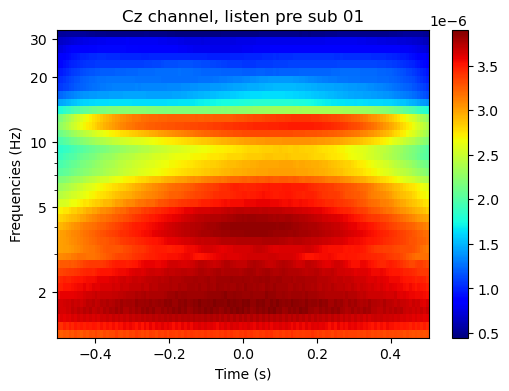

In [ ]:
channel = ['Cz']
ch_idx = ch_index(channel)
#ch_idx = 0 #working on arrays with only one channel index


test_wavelet = np.squeeze(wavelet_transform_mean[ch_idx,:,:])
plot_scaleogram(test_wavelet, freqs, times) 
plt.title(f'{channel[0]} channel, {task} {period} sub {sub}')

#### Plot topomap for a frequency band

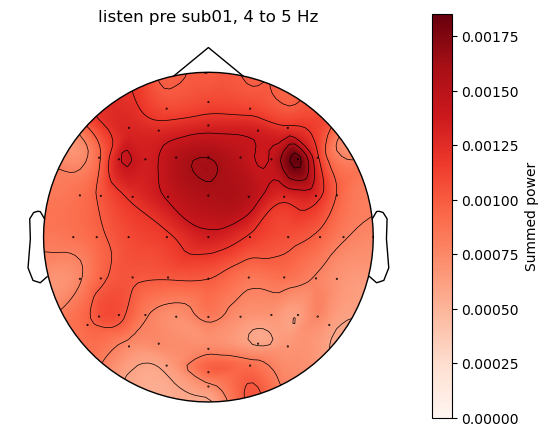

In [ ]:
freq_band = [4,5] #10-15 for beta, 4-5 for listening-related ERP
power_ch = sum_over_channels(wavelet_transform_mean, freq_band, freqs)

fig, ax = plt.subplots()
ax.set_title(f'{task} {period} sub{sub}, {freq_band[0]} to {freq_band[1]} Hz')


#plot this last
pos = load_ep_info()
im, _=mne.viz.plot_topomap(power_ch, pos, axes = ax, show = False)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Summed power')




In [ ]:
wavelet_transform_mean.shape

(64, 40, 129)

Text(0.5, 0, 'freqs')

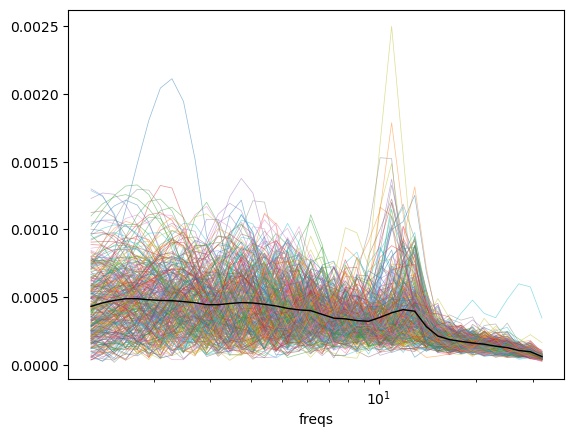

In [ ]:
#try to look at variability
wavelet_transform.shape

for trial in range(wavelet_transform.shape[0]):
    wavelet_trial = wavelet_transform[trial, 47, :,:].squeeze()
    trial_sum = np.sum(wavelet_trial, axis = 1)
    trial_sum.shape
    plt.plot(freqs, trial_sum, linewidth = 0.5, alpha = 0.5)

plt.plot(freqs, np.sum(wavelet_transform_mean[47], axis = 1), color = 'black', linewidth = 1)

plt.xscale('log')
plt.xlabel('freqs')

### Wavelet for multiple subjects listen and motor

In [477]:
def power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum, already_ave = False, ch_to_process = None):

    """ 
    NOTES: Currently assumes that all data contains only one channel

    Averages the wavelets over trials before processing

    Sums the power over time for multiple subjects
    freqs_to_sum: Range of freqs to sum over from low to high bound, or 'all'
        if 'all', the dataframe will return power as arrays of size freqs x power
    
    ---
    returns: dataframe with colums for subjects, periods, musicianship, and summed power at each frequency
    dims of summed power: 1 x n_freqs if freqs_to_sum = 'all'. Otherwise a float.
    """

    
    info_path = os.path.join(wavelet_dir, "wavelet_record.mat")
    wavelet_trans_info = loadmat(info_path)
    freqs = wavelet_trans_info['freqs'][0]

    power_df = pd.DataFrame(columns=['subject', 'musician', 'period', 'power'])
    _, _, musicians, _ = load_subject_lists()

    for wavelet_file in sorted(os.listdir(wavelet_dir)):
        sub_id = wavelet_file.split(".")[0].split('_')[-1]
        period =  wavelet_file.split(".")[0].split('_')[-2]

        if sub_id not in subjects_to_process:
            print(f'skipping sub {sub_id}')
            continue
        
        #loading data
        data = loadmat(os.path.join(wavelet_dir, wavelet_file))
        wavelet_sub = data['wavelet_transform']

        
        #averages data only if it has not already been averaged 
        if not already_ave: 
            wavelet_sub_ave = np.mean(wavelet_sub, axis = 0).squeeze()
        else: 
            wavelet_sub_ave = wavelet_sub
            
        #ensures that only one channel is present in data

        if ch_to_process != None: 
            ch_idx = ch_index(ch_to_process)
            wavelet_sub_ave = wavelet_sub_ave[ch_idx, :,:].squeeze()
            
        assert len(wavelet_sub_ave.shape) == 2, f'wavelet data should contain one channel only. Data shape is {wavelet_sub_ave.shape}'
        

        #take subset that is relevant for the frequency
        if isinstance(freqs_to_sum, str) and freqs_to_sum == 'all':
            power_arr = np.zeros(wavelet_sub_ave.shape[0])
            for i, freq in enumerate(freqs): 
                
                power = sum_wavelet_power(wavelet_sub_ave, [freq], freqs)
                power_arr[i] = power
        else:
            power_arr = sum_wavelet_power(wavelet_sub_ave, freqs_to_sum, freqs)
            
        
        #add to dataframe
        power_df_sub = pd.DataFrame({
            'subject': sub_id,
            'period': period,
            'power': [power_arr]

        })
        if sub_id in musicians:
            power_df_sub['musician'] = 1
        else: 
            power_df_sub['musician'] = 0
        power_df = pd.concat([power_df, power_df_sub])

    return power_df
            


In [596]:
task = 'listen'
ch_to_visualize = ['Cz']

wavelet_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz_all_ave'
subjects_to_process = find_existing_subjects(wavelet_dir)
#subjects_to_process = ['13', '18', '12', '02']
print('processing subjects', subjects_to_process)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

processing subjects ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']


##### Initialize directories

In [597]:
"""period = 'pre'
task = 'listen'
channels = 'Cz'"""

power_df_all = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_45 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[4,5])
power_df_1220 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[12,20])

power_musicians_pre = power_df_all.query("musician == 1 & period == 'pre'")
power_musicians_post = power_df_all.query("musician == 1 & period == 'post'")
power_nonmusicians_pre = power_df_all.query("musician == 0 & period == 'pre'")
power_nonmusicians_post = power_df_all.query("musician == 0 & period == 'post'")

power_all_pre = power_df_all.query("period == 'pre'")
power_all_post = power_df_all.query("period == 'post'")

skipping sub record
skipping sub record
skipping sub record


In [598]:
def plot_power_freqs(freqs, power_data, label = None, color = None, normalize = False ):
    """
    makes a plot of power vs freq
    freqs: x axis data (vector of freqs from wavelet info)
    power_data: 2d array n_subjects x n_freqs
    
    """
    if isinstance (power_data, pd.DataFrame):
    # Assuming power_df_all['power'] is a 2D array where rows are observations (e.g., trials or subjects) and columns are frequencies
        power = np.array(power_data['power'].tolist())  # Convert to numpy array if it's not already
    else: 
        assert isinstance(power_data, np.ndarray)
        power = power_data


    power_mean = power.mean(axis=0)  # Mean across observationa    
    
    #normalize aggregated data
    if normalize:
        power_mean = power_mean/power_mean.max()

    ##### TO FIX: sem is too small to show up
    power_sem = power.std(axis=0, ddof=1) / np.sqrt(power.shape[0])  # SEM computation

    

    # Plot the mean power spectrum
    plt.plot(freqs, power_mean, label = label, color = color)

    # Add SEM as a shaded region
    plt.fill_between(freqs, 
                    power_mean - power_sem, 
                    power_mean + power_sem, 
                    color = color,
                    alpha=0.3)
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')

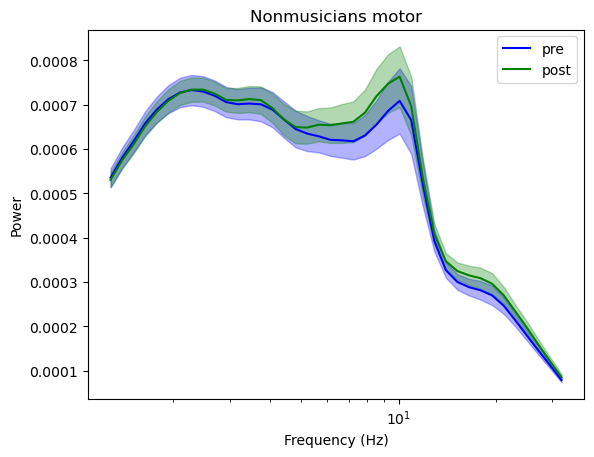

In [599]:
plot_power_freqs(freqs, power_all_pre, color = 'blue', label = 'pre', normalize= False)
plot_power_freqs(freqs, power_all_post, color = 'green', label = 'post', normalize= False)
plt.title('Nonmusicians motor')
plt.legend()


Difference in power

In [600]:
power_diff = power_all_post['power']-power_all_pre['power']
power_diff = np.vstack(power_diff)

Text(0.5, 1.0, 'Motor difference post-pre, good musicians')

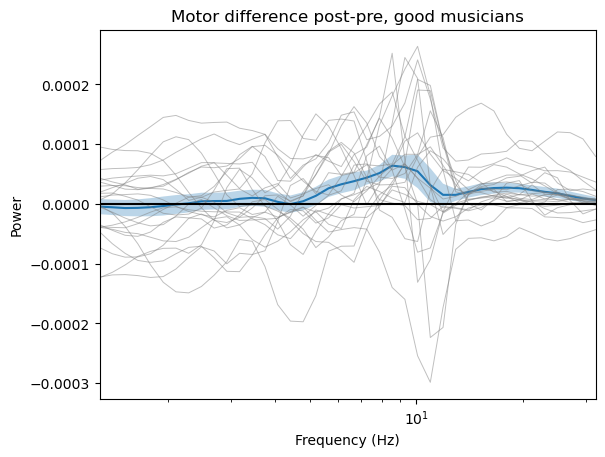

In [601]:
plot_power_freqs(freqs,power_diff)
for sub in range(power_diff.shape[0]):
    plt.plot(freqs, power_diff[sub, :], color = 'grey', alpha = 0.5, linewidth = 0.7)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])
plt.title(f'Motor difference post-pre, good musicians')

In [608]:
def gaussian_test(array, axis = 0):
    """
    KS test to determine whether the data is normally distributed. 
    Takes an array of shape [n_participants, n_timepoints] and determines whether distribution 
    is normal at each timepoint.
    axis: which axis of the array to test the array over
    ---
    Returns:
    significance: p-value of KS test averaged over all timepoints
    """
    n_points = array.shape[axis]
    p_values = []
    
    for timepoint in range(0, n_points):
        res = kstest(array[:,timepoint], 'norm')
        p_values.append(res.pvalue)

    p_values = np.array(p_values)
    print(f'testing gaussianity over {n_points} points')
    significance = p_values.mean()

    if significance > 0.05: 
        print("Distribution is normal. p = ", significance)
    elif significance < 0.04:
        print("Distribution is not normal. p = ", significance)

    return significance

In [630]:
def t_within_points(array):
    """ 
    compare within-subjects samples along an axis of points (e.g. times or freqs)
    uses the 1-sample t-test if normal and wilcoxon otherwise

    array: array of shape n_subs x n_points
    subaxis: which dim contains the subjects
    pointaxis: which dim contains the 
    ---
    returns: (both of shape n_points)
    t: a list of t statistics
    p: a listp values, one p value for each time point
    """
    n_points = array.shape[1]
    ks = gaussian_test(array, axis = 0)


    test_stats = []
    p_values = []

    if ks > 0.05:
        print('using 1samp ttest')
        test_function = lambda array, point: ttest_1samp(array[:, point])
    elif ks < 0.05:
        print('using wilcoxon test')
        test_function = lambda array, point: wilcoxon_1samp(array[:, point])

    for point in range(n_points):
        res = test_function(array, point)
        test_stats.append(res.statistic)
        p_values.append(res.pvalue)
    
    """    for point in range(n_points):

        if ks > 0.05:
            print('using 1samp ttest')
            res = ttest_1samp(array[:, point])
            test_stats.append(res.statistic)
            p_values.append(res.pvalue)
        elif ks < 0.05:
            print('using wilcoxon test')
            res = wilcoxon_1samp(array[:, point])
            test_stats.append(res.statistic)
            p_values.append(res.pvalue)"""

    return test_stats, p_values


stats, p_values = t_within_points(power_diff)


testing gaussianity over 21 points
Distribution is not normal. p =  2.227850420151978e-05
using wilcoxon test


In [631]:
p_values

[0.10321426391601562,
 0.07598018646240234,
 0.02385425567626953,
 0.011346817016601562,
 0.017546653747558594,
 0.0013742446899414062,
 0.00042629241943359375,
 0.000720977783203125,
 0.0021514892578125,
 0.010125160217285156,
 0.01947307586669922,
 0.16780662536621094,
 0.27221012115478516,
 0.12807846069335938,
 0.05469322204589844,
 0.0021514892578125,
 0.00042629241943359375,
 0.0006074905395507812,
 0.0024824142456054688,
 0.02901458740234375,
 0.05469322204589844,
 0.12807846069335938,
 0.3376598358154297,
 0.5620746612548828,
 0.945744514465332,
 0.8381938934326172,
 0.6578273773193359,
 0.6332969665527344,
 0.6578273773193359,
 0.6578273773193359,
 0.8917322158813477,
 1.0,
 0.945744514465332,
 1.0,
 0.8648872375488281,
 0.785365104675293,
 0.6578273773193359,
 0.6332969665527344,
 0.785365104675293,
 0.945744514465332]

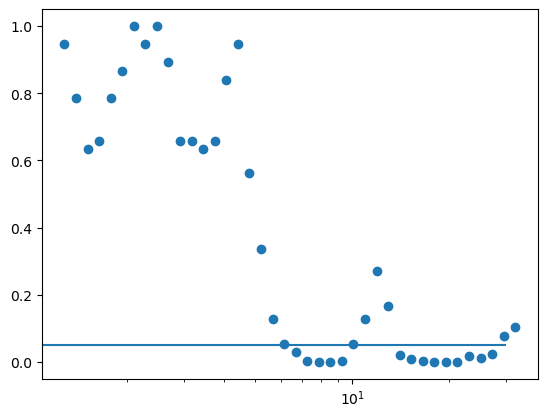

In [632]:
plt.scatter(freqs, p_values)
plt.hlines(0.05, 0, 30)
plt.xscale('log')

#### Mus vs nmus

In [595]:
def find_power_diff(power_df):
    """ 
    Finds post-pre values for a given power dataframe
    ---
    Returns a dataframe with pre, post, and difference
        TO DO: get rid of the pre and post to save on memory??
    """
    power_pivot = power_df.pivot(index =[ 'subject', 'musician'], columns = 'period', values = 'power')
    power_pivot['diff'] = power_pivot['post'] - power_pivot['pre']
    return power_pivot

In [ ]:
power_diff_1220 = find_power_diff(power_df_1220)
power_diff_45 = find_power_diff(power_df_45)

Text(0.5, 1.0, 'Power difference post - pre, 12-20 Hz')

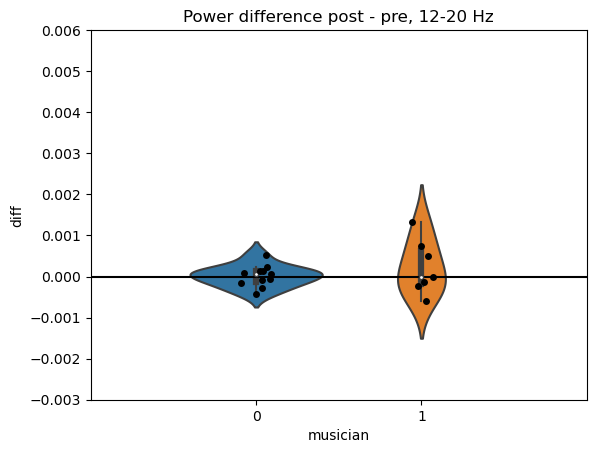

In [ ]:
sns.violinplot(data=power_diff_1220, x = power_diff_1220.index.get_level_values(1), y = 'diff')
sns.stripplot(data=power_diff_1220, x = power_diff_1220.index.get_level_values(1), y = 'diff', color = 'black')
plt.hlines(0, -1,2, color = 'black')

plt.xlim(-1,2)
plt.ylim(-0.003, 0.006)
plt.title('Power difference post - pre, 12-20 Hz')


Power over a band

(0.0, 0.008)

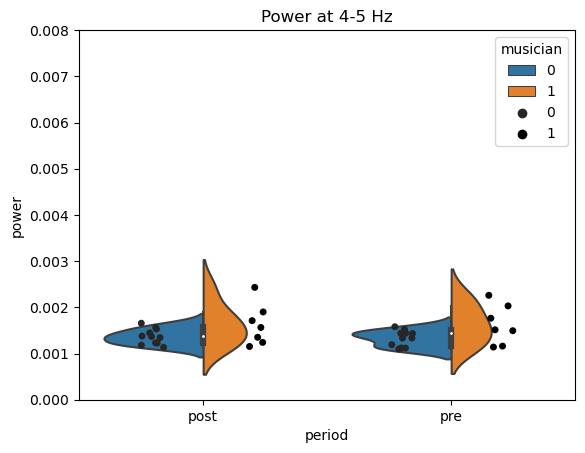

In [ ]:
sns.violinplot(data = power_df_45, x = 'period', y = 'power', hue = 'musician', split = True)
sns.stripplot(data = power_df_45, x = 'period', y = 'power', hue = 'musician', color = 'black', dodge=True)
plt.title('Power at 4-5 Hz')
plt.ylim(0, 0.008)

#### Topomap

In [ ]:
def power_over_channels(subjects_to_process, wavelet_dir, freq_band, period = None):
    """ 
    Extracts the power at each channel in a specified band, makes the data ready to topoplot
    freq_band: list of freqs representing lower and upper bound
    period: 'pre' or 'post'. If None, combines the two periods
    ---
    Returns array of size n_subjects x n_channels
    """
    info_path = os.path.join(wavelet_dir, "wavelet_record.mat")
    wavelet_trans_info = loadmat(info_path)
    freqs = wavelet_trans_info['freqs'][0]

    _, _, musicians, _ = load_subject_lists()

    wavelet_sum_list = []
    for wavelet_file in sorted(os.listdir(wavelet_dir)):
            
        sub_id = wavelet_file.split(".")[0].split('_')[-1]
        if sub_id not in subjects_to_process:
            print(f'skipping sub {sub_id}')
            continue
        
        #check the period. 
        if period != None:
            sub_period =  wavelet_file.split(".")[0].split('_')[-2]
            if sub_period != period:
                continue
    
        
        data = loadmat(os.path.join(wavelet_dir, wavelet_file))
        wavelet_sub = data['wavelet_transform']
      

        freq_idx = index_custom(freq_band, freqs)
        wavelet_sub_freq = wavelet_sub[:, np.min(freq_idx):np.max(freq_idx), :]
        
        wavelet_sum = np.sum(wavelet_sub_freq, axis = (1,2))
        wavelet_sum_list.append(wavelet_sum)
    
    wavelet_sum_arr = np.array(wavelet_sum_list)
    
    return wavelet_sum_arr





In [ ]:
def plot_topo_custom(topo_data, pos, colorbar=False, title = None):
    """  
    uses mne plot topo function to plot a nice topomap with my favourite parameters 
    NOT COMPLETELY POLISHED BUT USABLE
    """
    fig, ax = plt.subplots()
    im, _ = mne.viz.plot_topomap(topo_data, pos, axes=ax, show=False)
    if colorbar:
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7)
        cbar.set_label('Amplitude (µV)', rotation=270, labelpad=15) 

    if title != None:
        ax.set_title(title)
    plt.show()

skipping sub record


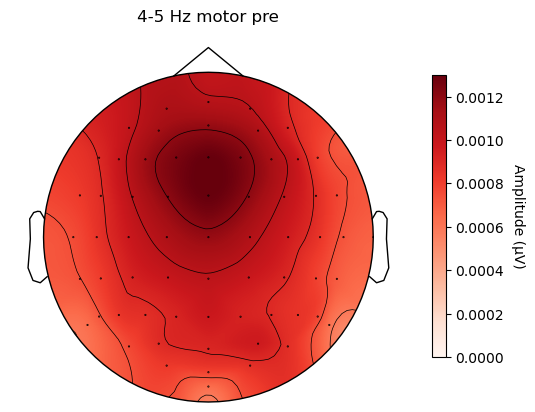

In [ ]:
pos = load_ep_info()
period = 'pre'

topo_45 = power_over_channels(subjects_to_process, wavelet_dir, [4,5], period)
topo_45_mean = np.mean(topo_45, axis = 0)
plot_topo_custom(topo_45_mean, pos, colorbar=True, title = f'4-5 Hz {task} {period}')



skipping sub record


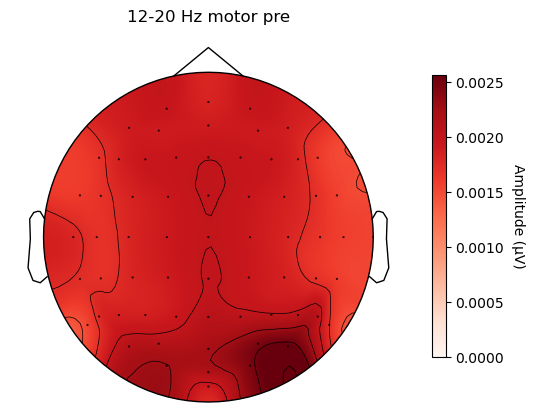

In [ ]:
topo_1220 = power_over_channels(subjects_to_process, wavelet_dir, [10,15], period)
topo_1220_mean = np.mean(topo_1220, axis = 0)
plot_topo_custom(topo_1220_mean, pos, colorbar=True, title = f'12-20 Hz {task} {period}')


In [ ]:


def plot_over_subs(data, pos, sup_title = None):
    n_subs = data.shape[0]
    
    # Determine grid size (rows and columns)
    n_cols = math.ceil(np.sqrt(n_subs))
    n_rows = math.ceil(n_subs / n_cols)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.array(axes).flatten()  # Flatten axes for easier indexing
    
    for sub in range(n_subs):
        topo_sub = data[sub, :]
        
        # Plot the topomap for each subject
        mne.viz.plot_topomap(topo_sub, pos, axes=axes[sub], show=False)
        axes[sub].set_title(f"Sub {sub + 1}")
    
    # Hide unused subplots
    for ax in axes[n_subs:]:
        ax.axis('off')
    
    if sup_title!= None:
        fig.suptitle(sup_title, fontsize = 20)

    plt.tight_layout()
    plt.show()
    


In [ ]:
#plot_over_subs(topo_1220, pos, sup_title=f'{task} {period} 12-20 Hz')
#plot_over_subs(topo_45, pos, sup_title=f'{task} {period} 4-5 Hz')


## Wavelet for multiple subjects training

In [ ]:
task = 'training'
ch_to_visualize = ['Cz']

wavelet_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz_all_ave'
subjects_to_process = find_existing_subjects(wavelet_dir)
print('processing subjects', subjects_to_process)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()
##### Initialize directories
"""period = 'pre'
task = 'listen'
channels = 'Cz'"""


processing subjects ['05', '06', '07', '08', '09', '10', '11', '12']


"period = 'pre'\ntask = 'listen'\nchannels = 'Cz'"

In [ ]:

power_df_all = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_45 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[4,5])
power_df_1220 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[12,20])


skipping sub record
skipping sub record
skipping sub record


In [ ]:
power_mus_train = power_df_all.query('musician == 1')
power_nmus_train = power_df_all.query('musician == 0')

Text(0.5, 1.0, 'training (normalized)')

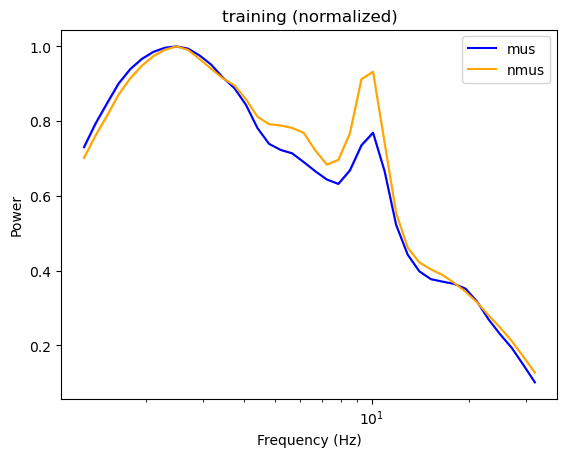

In [ ]:
plot_power_freqs(freqs, power_mus_train, color = 'blue', label = 'mus', normalize = True)
plot_power_freqs(freqs, power_nmus_train, color = 'orange', label = 'nmus', normalize=True)
plt.legend()
plt.title('training (normalized)')

## Comparing listen motor to training

In [ ]:
ch_to_visualize = ['Cz']

wavelet_dir_l = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_listen__n05to05_30Hz_all_ave'
wavelet_dir_m = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_motor__n05to05_30Hz_all_ave'
wavelet_dir_t = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_training__n05to05_30Hz_all_ave'

#use motor folder as reference because the subjects are more limited
subjects_to_process = find_existing_subjects(wavelet_dir_m)
print('processing subjects', subjects_to_process)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir_m,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()
##### Initialize directories
"""period = 'pre'
task = 'listen'
channels = 'Cz'"""

power_df_all_l = power_over_subs(subjects_to_process, wavelet_dir_l, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_all_m = power_over_subs(subjects_to_process, wavelet_dir_m, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_all_t = power_over_subs(subjects_to_process, wavelet_dir_t, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)


power_mus_pre_l = power_df_all_l.query("musician == 1 & period == 'pre'")
power_mus_post_l = power_df_all_l.query("musician == 1 & period == 'post'")
power_mus_pre_m = power_df_all_m.query("musician == 1 & period == 'pre'")
power_mus_post_m = power_df_all_m.query("musician == 1 & period == 'post'")

power_nmus_pre_l = power_df_all_l.query("musician == 0 & period == 'pre'")
power_nmus_post_l = power_df_all_l.query("musician == 0 & period == 'post'")
power_nmus_pre_m = power_df_all_m.query("musician == 0 & period == 'pre'")
power_nmus_post_m = power_df_all_m.query("musician == 0 & period == 'post'")

processing subjects ['01', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '18', '19', '20']
skipping sub 02
skipping sub 17
skipping sub 21
skipping sub 02
skipping sub 17
skipping sub 21
skipping sub record
skipping sub record
skipping sub record


In [ ]:
power_mus_pre_lm = np.array(power_mus_pre_l['power'].tolist()) + np.array(power_mus_pre_m['power'].tolist())


In [ ]:
power_t = np.array(power_df_all_t['power'].tolist()) 

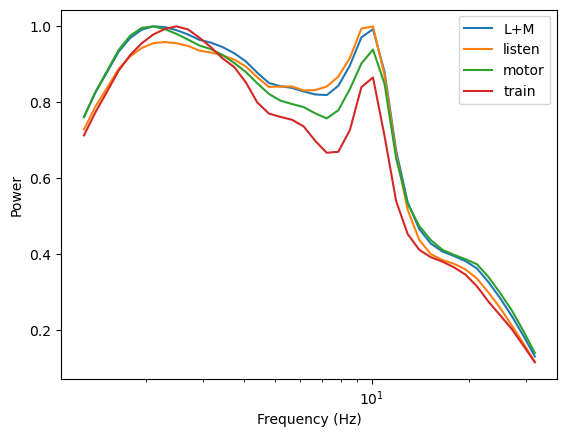

In [ ]:
#norm_l_mus_pre = power_mus_pre_l.mean(axis = 0)
normalize = True
plot_power_freqs(freqs,power_nmus_pre_lm, normalize= normalize, label = 'L+M')
plot_power_freqs(freqs, power_nmus_pre_l, normalize=normalize, label = "listen")
plot_power_freqs(freqs, power_nmus_pre_m, normalize=normalize, label = 'motor')
plot_power_freqs(freqs, power_t, normalize=normalize, label = 'train')
plt.xscale('log')
plt.legend()